In [27]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pickle
from scipy.interpolate import griddata
import csv
from PIL import Image
from IPython.display import display, Image as IPImage
import os

from pyproj import Transformer
import matplotlib.tri as mtri

%run -i wave_stats.py
%run -i storm_coords.py

In [4]:
data_dir  = "F:/crs/proj/2025_NOPP_comparison/helene_adcirc_model_results/bulk_wave_stats/"
fname = "allnodes_sig_waveheight_ts_swan_HS_63.nc"
ds_Hs = xr.open_dataset(data_dir+fname, chunks={"time": 8})
adcirc_time = ds_Hs['time']
ds_Hs

<xarray.Dataset> Size: 8GB
Dimensions:      (time: 431, node: 2219482, nfaces: 4398700, nvertex: 3,
                  nope: 1, neta: 186, nbou: 73, nvel: 40294)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2022-09-23T12:15:00 ... 2022-09-27...
    x            (node) float64 18MB dask.array<chunksize=(443897,), meta=np.ndarray>
    y            (node) float64 18MB dask.array<chunksize=(443897,), meta=np.ndarray>
Dimensions without coordinates: node, nfaces, nvertex, nope, neta, nbou, nvel
Data variables:
    element      (nfaces, nvertex) int32 53MB dask.array<chunksize=(1099675, 1), meta=np.ndarray>
    adcirc_mesh  int32 4B ...
    nvdll        (nope) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    ibtypee      (nope) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    nbdv         (neta) int32 744B dask.array<chunksize=(186,), meta=np.ndarray>
    nvell        (nbou) int32 292B dask.array<chunksize=(73,), meta=np.ndarray>
    ibtype       (nbou) int32 292B dask.array<chunksize=(73,), meta=np.ndarray>
    nbvv         (nvel) int32 161kB dask.array<chunksize=(40294,), meta=np.ndarray>
    depth        (node) float64 18MB dask.array<chunksize=(443897,), meta=np.ndarray>
    swan_HS      (time, node) float64 8GB dask.array<chunksize=(8, 443897), meta=np.ndarray>
Attributes: (12/50)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            v56.0.4
    git_hash:           5e5905d7e4b330b5c4c263d4253136c3199155f3
    grid_type:          Triangular
    description:        Helene Reanalysis 89
    ...                 ...
    sfea0:              28.38
    cf:                 0.0
    eslm:               -0.2
    cori:               0.0
    ntif:               7
    nbfr:               7

In [8]:
# Node coords - convert to easting and northing
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32617", always_xy=True)
x, y = transformer.transform(ds_Hs["x"].values, ds_Hs["y"].values )

# Triangle connectivity; often 1-based in ADCIRC, so subtract 1
triangles = ds_Hs["element"].values.astype(np.int64) - 1   # shape (nfaces, 3)

In [9]:
# Load the contour file
contour_file = 'contour30sp.csv'
df = pd.read_csv( contour_file )
contour30sp = np.column_stack( (df['contour30s_lon'], df['contour30s_lat']) )
normals30sp = np.column_stack( (df['normals30_x'], df['normals30_y']) )
xy30sp = np.column_stack( (df['contour30s_x'], df['contour30s_y']) )
# generic names
contour_points = contour30sp
normals = normals30sp
contour_xy = xy30sp

# contour_easting, contour_northing = ...
xp = np.asarray(contour_xy[:,0], dtype=float)
yp = np.asarray(contour_xy[:,1], dtype=float)

In [10]:
# --- Build triangulation & find containing triangle for each contour point ---
tri = mtri.Triangulation(x, y, triangles=triangles)
trifinder = tri.get_trifinder()             # fast point->triangle locator
face_idx = trifinder(xp, yp)                # shape (npoints,), -1 if outside

if np.any(face_idx < 0):
    bad = np.where(face_idx < 0)[0]
    raise ValueError(f"{bad.size} contour points fall outside the mesh; "
                     "you can clip/adjust points or switch to nearest-IDW there.")

In [11]:
# For each point, grab the three vertex node indices of its triangle:
v = triangles[face_idx, :]                   # (npoints, 3) node indices

# --- Barycentric weights for each point within its triangle ---
# Vectorized formula:
x0 = x[v[:, 0]]; y0 = y[v[:, 0]]
x1 = x[v[:, 1]]; y1 = y[v[:, 1]]
x2 = x[v[:, 2]]; y2 = y[v[:, 2]]

den = ( (y1 - y2)*(x0 - x2) + (x2 - x1)*(y0 - y2) )  # (npoints,)
w0 =  ( (y1 - y2)*(xp - x2) + (x2 - x1)*(yp - y2) ) / den
w1 =  ( (y2 - y0)*(xp - x2) + (x0 - x2)*(yp - y2) ) / den
# TODO would it be better to calculate w2 with the same formula and then normalize
# Won't be faster, but might be a good way to check
w2 = 1.0 - w0 - w1

weights = np.stack([w0, w1, w2], axis=1)             # (npoints, 3)

# Sanity check: weights should sum to ~1
assert np.allclose(weights.sum(axis=1), 1.0, atol=1e-6)

In [13]:
npoints, ncorners = v.shape  # ncorners = 3 for triangles
assert ncorners == 3

# Wrap indices and weights with labeled dims
idx_da = xr.DataArray(v.astype(np.int64), dims=("point", "corner"))         # (point, corner)
w_da   = xr.DataArray(weights,            dims=("point", "corner"))         # (point, corner)

Dir_fname = "allnodes_direction_ts_swan_DIR_63.nc"
ds_Dir = xr.open_dataset(data_dir+Dir_fname, chunks={"time": 8})

Tps_fname = "allnodes_TPSperiod_ts_swan_TPS_63.nc"
ds_Tps = xr.open_dataset(data_dir+Tps_fname, chunks={"time": 8})

In [43]:
# --- Static variable depth -> shape (point, corner)
depth_pc = ds_hs["depth"].isel(node=idx_da)                                 # (point, corner)

# --- Time-varying variables (Hs, Tp, Dir) -> shape (time, point, corner)
Hs_tpc = ds_Hs["swan_HS"].isel(node=idx_da)     # (time, point, corner)
Dir_tpc = ds_Dir["swan_DIR"].isel(node=idx_da)  # (time, point, corner)
Tps_tpc = ds_Tps["swan_TPS"].isel(node=idx_da)  # (time, point, corner)

# Directional components of Dir
xDir_tpc, yDir_tpc = xycoord( 1, Dir_tpc )

# Interpolate to contour points with barycentric weights
depth_point = (depth_pc * w_da).sum(dim="corner")                           # (point,)
Hs_tp = (Hs_tpc * w_da).sum(dim="corner")                                   # (time, point)
Hs_tp.name = "Hs_at_contour_points"


# Weighted RMS deviation (time, point)
Hs_wrms = (((Hs_tpc - Hs_tp)**2 * w_da).sum("corner"))**0.5
Hs_wrms.name = "Hs_weighted_rms_deviation"

# Some optional companion metrics:
Hs_range = (Hs_tpc.max("corner") - Hs_tpc.min("corner"))  # (time, point)
Hs_cv    = Hs_wrms / xr.where(Hs_tp != 0, Hs_tp, np.nan)  # coefficient of variation

In [44]:
# Calculate Eflux at the vertices
Eflux_tpc = calc_Eflux( Hs_tpc, Tps_tpc, depth_pc )
# Use barycentric weights
Eflux_tp = (Eflux_tpc * w_da).sum(dim="corner") # (time, point)
Eflux_rms = (((Eflux_tpc - Eflux_tp)**2 * w_da).sum("corner"))**0.5
xDir_tp = (xDir_tpc * w_da).sum(dim="corner")
yDir_tp = (yDir_tpc * w_da).sum(dim="corner")
# magnitude of directional components will be smaller...need to normalize
R, _ = pcoord( xDir_tp, yDir_tp )
eps = 1e-12
x_unit = xDir_tp.where(R > eps, 0.0) / xr.where(R > eps, R, 1.0)
y_unit = yDir_tp.where(R > eps, 0.0) / xr.where(R > eps, R, 1.0)
_, Dir_tp = pcoord( x_unit, y_unit )
# assert np.allclose( np.sqrt( x_unit**2 + y_unit**2 ), 1.0, atol=1e-4)

# Measure of directional spread around the triangle
# Circular resultant length R: 1 = perfectly aligned; 0 = uniformly spread
# Circular variance V = 1 - R ; Circular std (Fisher) ~ sqrt(-2 ln R) for R in (0,1]
circ_var = 1.0 - R
circ_std = xr.where((R > 0) & (R <= 1), np.sqrt(-2.0*np.log(R)), np.nan)

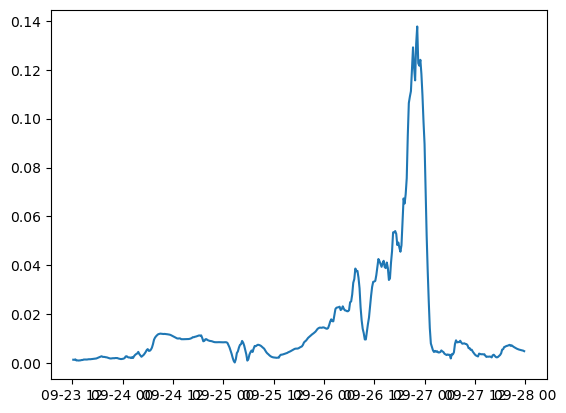

In [45]:
plt.plot(adcirc_time, Hs_wrms[:,320] )

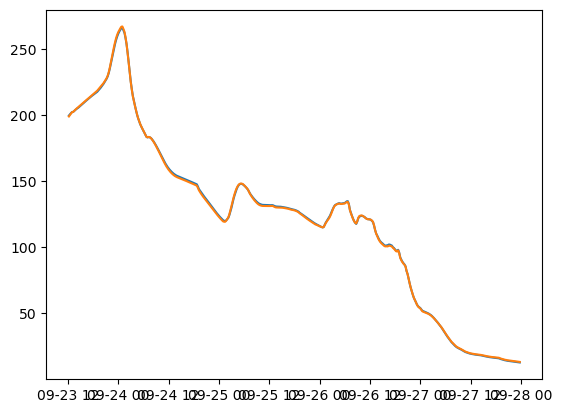

In [41]:
plt.plot(adcirc_time, Dir_tpc[:,320,0])
plt.plot(adcirc_time, Dir_tp[:,320])

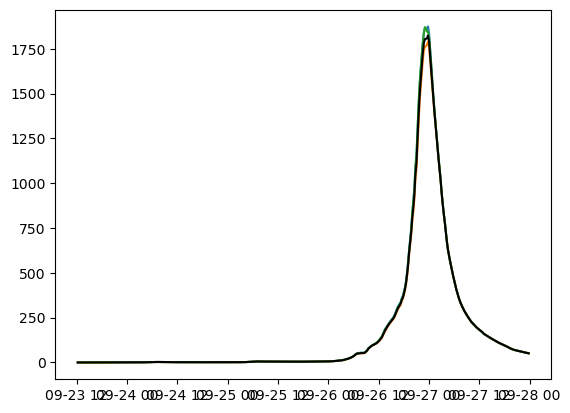

In [25]:
plt.plot(adcirc_time, Eflux_tpc[:,320,0])
plt.plot(adcirc_time, Eflux_tpc[:,320,1])
plt.plot(adcirc_time, Eflux_tpc[:,320,2])
plt.plot(adcirc_time, Eflux_tp[:,320], '-k')

In [ ]:
plt.plot(depth_sub[:])

In [ ]:
np.shape(HS_interp)
plt.plot(adcirc_time, HS_interp[:,350])